<a href="https://colab.research.google.com/github/Shivakumarsullagaddi/CCBD_MRI/blob/main/3D_RESNET3_CBAM_BC__6ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Binary Classification
#3D-ResNet

0 → CN (Not Alzheimer's)

1 → AD (Alzheimer's)



---
2D Model -> 3D ResNet Model + CBAM (Convolutional Block Attention Module)

---



**Problem :**
            

> model is little overfitting

> Model Generalization is Poor

>Missing Regularization

**learning**
<br>3D images needs more compution (GPUs) with CPU TAKES TIME

In [ ]:
#from load dataset from drive
from google.colab import drive
drive.mount('/content/drive')

#import
import os
import torch
import nibabel as nib
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision.models.video import r3d_18
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Mounted at /content/drive


In [ ]:
#use the CBAM
class ChannelAttention3D(nn.Module):
    def __init__(self, in_planes, ratio=8):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool3d(1)
        self.max_pool = nn.AdaptiveMaxPool3d(1)
        self.fc = nn.Sequential(
            nn.Conv3d(in_planes, in_planes // ratio, 1),
            nn.ReLU(),
            nn.Conv3d(in_planes // ratio, in_planes, 1)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        return x * self.sigmoid(avg_out + max_out)

class SpatialAttention3D(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv3d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        return x * self.sigmoid(self.conv(x_cat))

class CBAM3D(nn.Module):
    def __init__(self, in_planes):
        super().__init__()
        self.channel_att = ChannelAttention3D(in_planes)
        self.spatial_att = SpatialAttention3D()

    def forward(self, x):
        x = self.channel_att(x)
        x = self.spatial_att(x)
        return x


In [ ]:
#3DRESNET + CBAM
class ResNet3D_CBAM(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        base_model = r3d_18(weights=None)
        base_model.stem[0] = nn.Conv3d(1, 64, kernel_size=(3, 7, 7),
                                       stride=(1, 2, 2), padding=(1, 3, 3), bias=False)

        self.stem = base_model.stem
        self.layer1 = nn.Sequential(base_model.layer1, CBAM3D(64))
        self.layer2 = nn.Sequential(base_model.layer2, CBAM3D(128))
        self.layer3 = nn.Sequential(base_model.layer3, CBAM3D(256))
        self.layer4 = nn.Sequential(base_model.layer4, CBAM3D(512))
        self.avgpool = base_model.avgpool
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

model = ResNet3D_CBAM().to(device)


In [ ]:
class MRI3DDataset(Dataset):
    def __init__(self, samples, target_shape=(128, 128, 128), use_mask=False):
        self.samples = samples  # [(nii_path, label, mask_path (optional))]
        self.target_shape = target_shape
        self.use_mask = use_mask

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        paths = self.samples[idx]
        nii_path, label = paths[0], paths[1]
        img = nib.load(nii_path).get_fdata()

        if self.use_mask and len(paths) == 3:
            mask = nib.load(paths[2]).get_fdata()
            img *= mask  # Apply ROI mask

        img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)
        img = self.resize_volume(img, self.target_shape)
        img = img[np.newaxis, ...].astype(np.float32)
        return torch.tensor(img), label

    def resize_volume(self, volume, target_shape):
        factors = [t / s for s, t in zip(volume.shape, target_shape)]
        return zoom(volume, factors, order=1)


In [ ]:
root_dir = '/content/drive/MyDrive/MRI_DATASET/nifti_with_metadata/nifti_with_metadata'
class_map = {'CN': 0, 'AD': 1}
train_samples, val_samples, test_samples = [], [], []

random.seed(42)
for cls in ['CN', 'AD']:
    cls_dir = os.path.join(root_dir, cls)
    subjects = sorted(os.listdir(cls_dir))
    random.shuffle(subjects)

    n = len(subjects)
    splits = (int(0.7*n), int(0.15*n))  # train, val
    train_sub = subjects[:splits[0]]
    val_sub = subjects[splits[0]:splits[0]+splits[1]]
    test_sub = subjects[splits[0]+splits[1]:]

    for subset, sample_list in zip([train_sub, val_sub, test_sub], [train_samples, val_samples, test_samples]):
        for sub in subset:
            sub_dir = os.path.join(cls_dir, sub)
            nii_files = [f for f in os.listdir(sub_dir) if f.endswith('.nii') or f.endswith('.nii.gz')]
            if nii_files:
                nii_path = os.path.join(sub_dir, nii_files[0])
                sample_list.append((nii_path, class_map[cls]))


In [ ]:
#TRAINIG
batch_size = 2
target_shape = (128, 128, 128)
train_dataset = MRI3DDataset(train_samples, target_shape)
val_dataset = MRI3DDataset(val_samples, target_shape)
test_dataset = MRI3DDataset(test_samples, target_shape)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)

for epoch in range(15):
    model.train()
    total, correct, running_loss = 0, 0, 0
    for volumes, labels in train_loader:
        volumes, labels = volumes.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(volumes)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * volumes.size(0)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    val_correct = 0
    model.eval()
    with torch.no_grad():
        for volumes, labels in val_loader:
            outputs = model(volumes.to(device))
            _, preds = torch.max(outputs, 1)
            val_correct += (preds.cpu() == labels).sum().item()

    print(f"Epoch {epoch+1}: Loss={running_loss/total:.4f} "
          f"Train Acc={100*correct/total:.2f}% Val Acc={100*val_correct/len(val_dataset):.2f}%")


Epoch 1: Loss=0.7105 Train Acc=53.85% Val Acc=44.83%
Epoch 2: Loss=0.6853 Train Acc=57.34% Val Acc=48.28%
Epoch 3: Loss=0.6917 Train Acc=51.75% Val Acc=44.83%
Epoch 4: Loss=0.6935 Train Acc=55.24% Val Acc=58.62%
Epoch 5: Loss=0.6925 Train Acc=55.94% Val Acc=48.28%
Epoch 6: Loss=0.6970 Train Acc=55.94% Val Acc=58.62%
Epoch 7: Loss=0.6800 Train Acc=57.34% Val Acc=37.93%
Epoch 8: Loss=0.6871 Train Acc=58.04% Val Acc=51.72%
Epoch 9: Loss=0.6735 Train Acc=62.24% Val Acc=44.83%
Epoch 10: Loss=0.6672 Train Acc=62.94% Val Acc=44.83%
Epoch 11: Loss=0.6761 Train Acc=55.94% Val Acc=48.28%
Epoch 12: Loss=0.6731 Train Acc=61.54% Val Acc=48.28%
Epoch 13: Loss=0.6768 Train Acc=58.74% Val Acc=44.83%
Epoch 14: Loss=0.6437 Train Acc=62.94% Val Acc=55.17%
Epoch 15: Loss=0.6603 Train Acc=60.14% Val Acc=48.28%


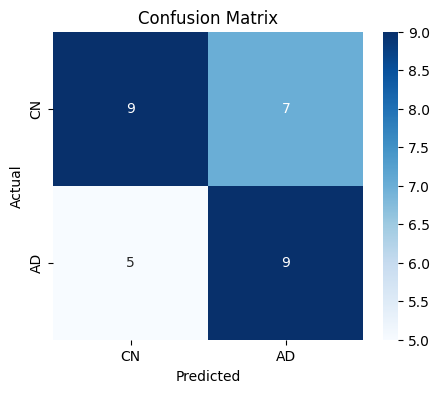

              precision    recall  f1-score   support

          CN       0.64      0.56      0.60        16
          AD       0.56      0.64      0.60        14

    accuracy                           0.60        30
   macro avg       0.60      0.60      0.60        30
weighted avg       0.61      0.60      0.60        30



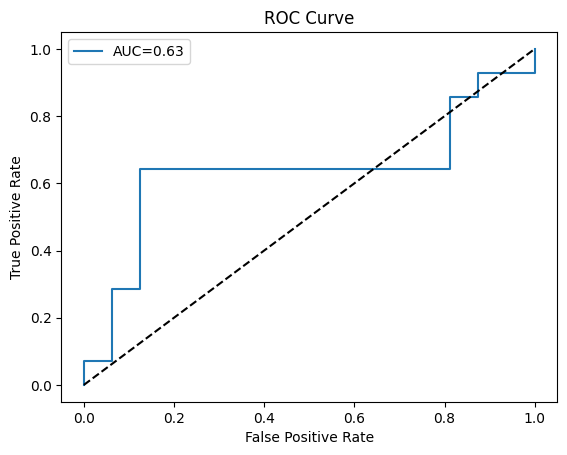

In [ ]:
#EVALUATION
model.eval()
all_preds, all_probs, all_targets = [], [], []

with torch.no_grad():
    for volumes, labels in test_loader:
        outputs = model(volumes.to(device))
        probs = torch.softmax(outputs, dim=1)[:, 1]
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_targets.extend(labels.numpy())

cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['CN', 'AD'], yticklabels=['CN', 'AD'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(all_targets, all_preds, target_names=['CN', 'AD']))

auc = roc_auc_score(all_targets, all_probs)
fpr, tpr, _ = roc_curve(all_targets, all_probs)
plt.plot(fpr, tpr, label=f"AUC={auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


#VISUALIZATION

/tmp/ipython-input-8-1628766997.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(volume[np.newaxis, ...]).to(device)
/tmp/ipython-input-8-1628766997.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(volume[np.newaxis, ...]).to(device)
/tmp/ipython-input-8-1628766997.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(volume[np.newaxis, ...]).to(device)


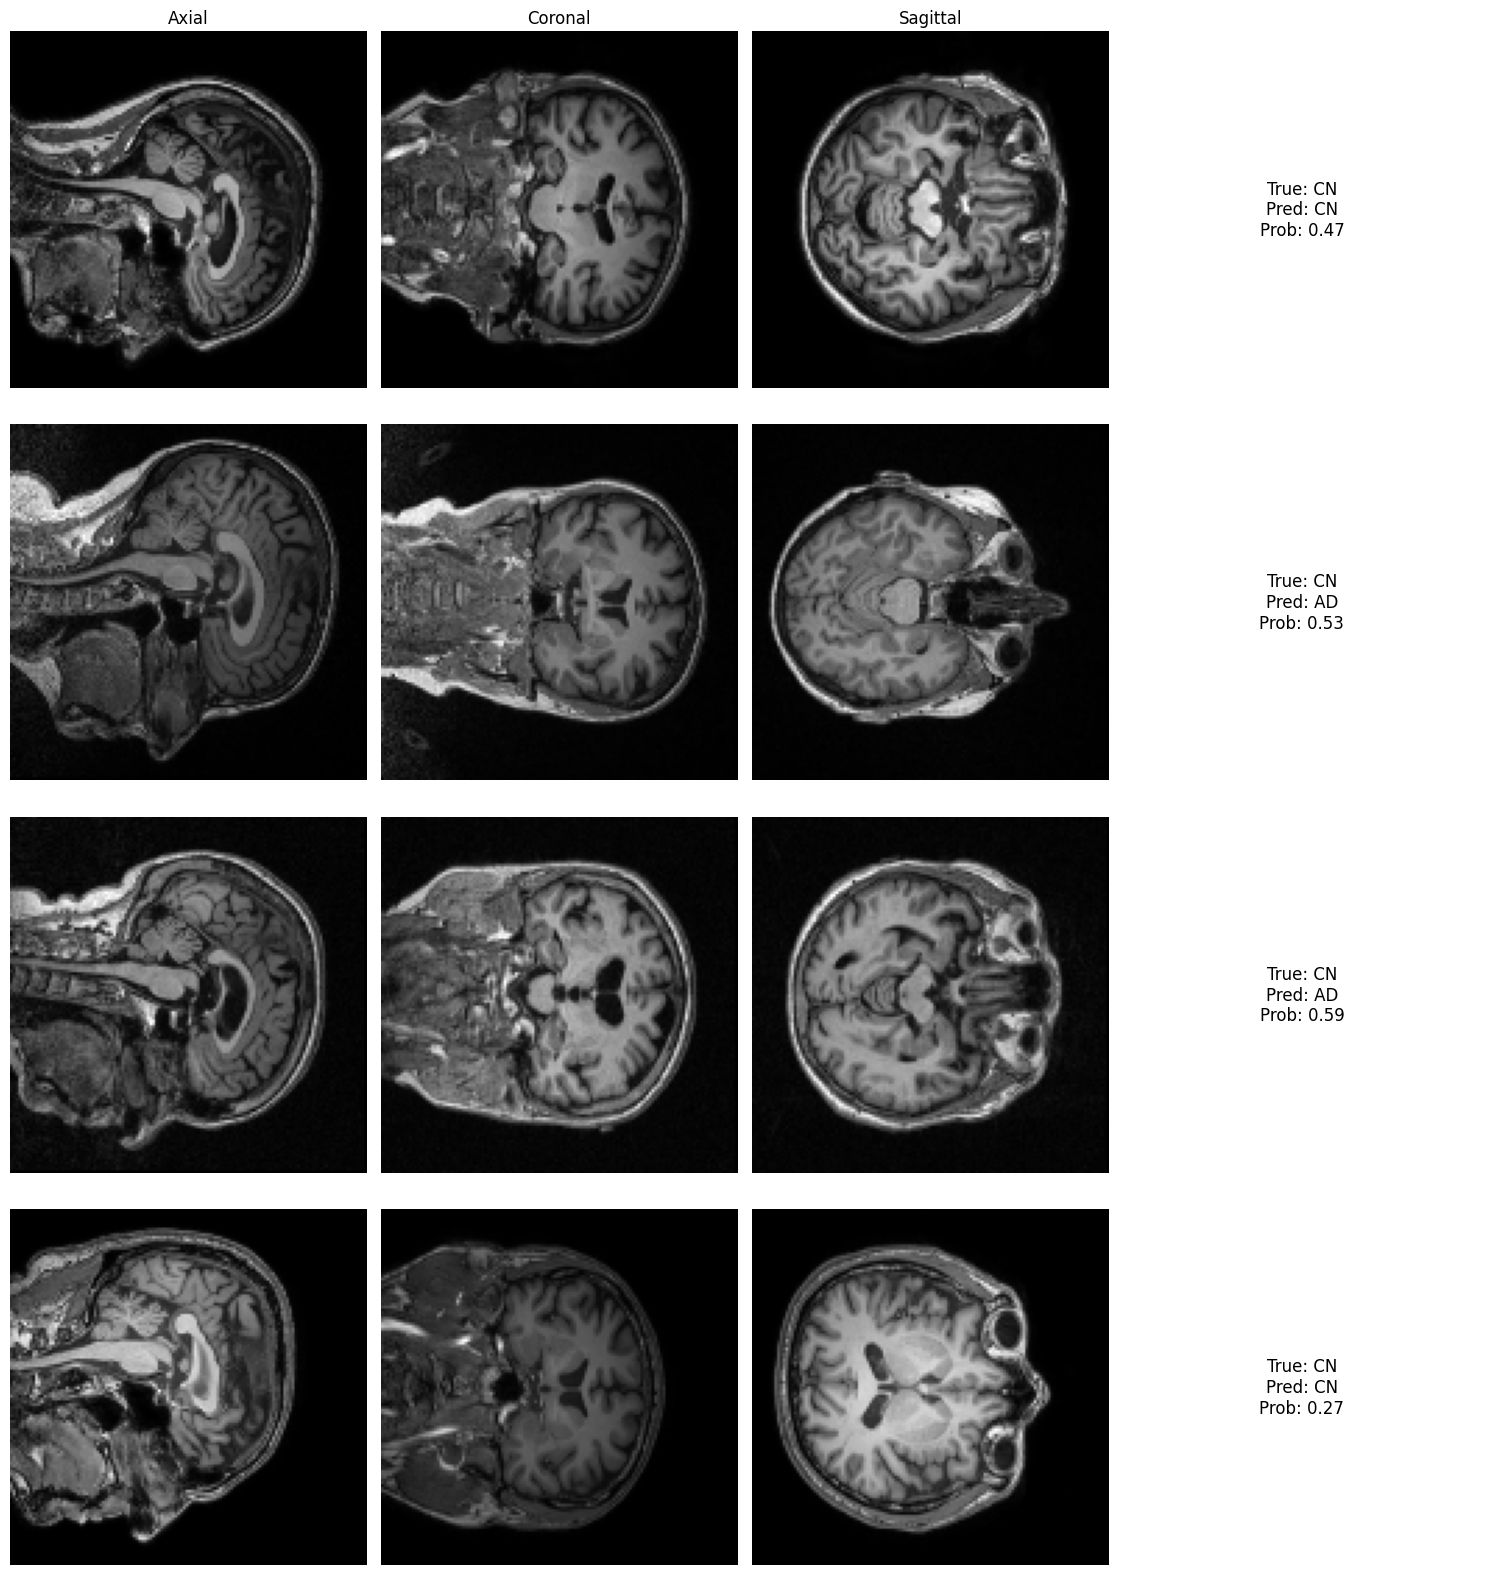

In [ ]:
num_examples = 4
fig, axes = plt.subplots(num_examples, 4, figsize=(15, 4*num_examples))

for idx in range(num_examples):
    volume, label = test_dataset[idx]
    volume_np = volume.numpy()[0]
    mid_z, mid_y, mid_x = [s//2 for s in volume_np.shape]

    slices = [volume_np[mid_z], volume_np[:, mid_y], volume_np[:, :, mid_x]]

    with torch.no_grad():
        input_tensor = torch.tensor(volume[np.newaxis, ...]).to(device)
        output = model(input_tensor)
        prob = torch.softmax(output, dim=1)[0, 1].item()
        pred = int(prob > 0.5)

    for j, s in enumerate(slices):
        ax = axes[idx, j]
        ax.imshow(s, cmap='gray')
        ax.axis('off')
        if idx == 0:
            ax.set_title(['Sagittal','Axial' ][j])

    ax = axes[idx, 3]
    ax.axis('off')
    ax.text(0.5, 0.5, f"True: {'AD' if label else 'CN'}\nPred: {'AD' if pred else 'CN'}\nProb: {prob:.2f}",
            ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.show()
